#### **Project Overview**

* Built a frontal face detection with gender and age prediction web-app from scratch on images taken from upload or camera and deployed to cloud for anyone to use.
* Used Streamlit to build front-end interface of the web-app.
* Cleaned, explored, engineered new features and manipulated the data to make it usable for our use case.
* Used transfer learning with pre-trained model **DenseNet121** to train our model because it is smaller in size(33 MB) in comparision with other pre-trained models(making our web-app efficient) and also has optimal number of parameters(8.1M) and depth(242) which is perfect for our use case.
* Trained two dense models separately, regression and binary classifier, to predict age and gender respectively.
* Tuned our model hyper-parameters to get optimal results.


##### **Project Introduction**

In this project I'll be using the UTKFace dataset which has around ~24,000 frontal face images to build a face detector with gender and age prediction web-app. I'll also be using transfer learning with pre-trained model **DenseNet121** to make better regression and classification models for our use case. To optimize performance, I'll try to tune and experiment with some hyper-parameters. Finally, I'll save the models and pack everything into a web-app using Streamlit and host it to cloud for anyone to use.

##### **Note:**
We will be using Google Colab for building and saving our model before loading it into our Streamlit web-app. This is because we can take advantage of the GPUs provided for free in Google Colab.

In [1]:
# downloading the UTKFace dataset
! kaggle datasets download -d jangedoo/utkface-new

 99% 328M/331M [00:02<00:00, 186MB/s]
100% 331M/331M [00:02<00:00, 165MB/s]


In [ ]:
# extracting the contents of download dataset
! unzip /content/utkface-new.zip

In [1]:
# importing all required libraries

import os
from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set the figure size for visualizations
sns.set(rc={'figure.figsize':(12,10)})

In [3]:
# we check the total number of frontal face images we have
img_count = len(os.listdir("/content/UTKFace"))
print("We have a total of", img_count, "images.")

We have a total of 23708 images.


In [4]:
# we extract the age and gender labels from the image file names and also the images themselves and store into lists
images = []
ages = []
genders = []

for i in os.listdir('/content/UTKFace')[:17000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('/content/UTKFace/' + i))

We will only be using 17000 images from the dataset because of the limited resources available to us in Google Colab.

In [5]:
# we concatenate the extracted information in lists into a dataframe to make it easier to use further
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)

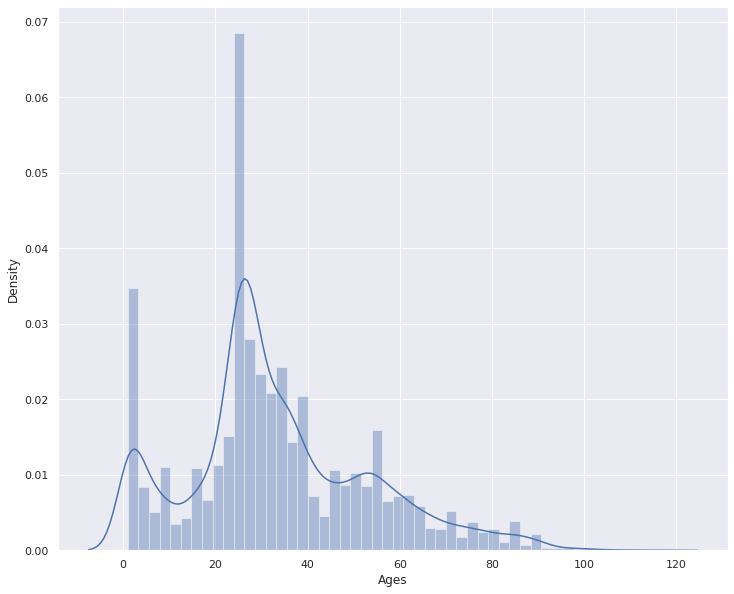

In [6]:
# we plot the distribution of ages to check if its balanced enough for training
sns.distplot(df['Ages'], kde=True, bins=50);

We see that there are 2 bands of age where we have an imbalance. We will try to normalize our dataset by removing a fraction of images from those bands.

In [7]:
# we check the value counts
df["Ages"].value_counts().sort_values(ascending=False)[:5]

26    1558
1      796
28     660
35     642
24     586
Name: Ages, dtype: int64

In [8]:
# we remove 70% of all images of people of age less than 4 years

under4s = []
for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)
df = df[df['Ages'] > 4]
df = pd.concat([df, under4s], ignore_index = True)

In [9]:
# we also reduce the number of images of people of age 26 by 60%

t26s = []
for i in range(len(df)):
    if df['Ages'].iloc[i] == 26:
        t26s.append(df.iloc[i])
t26s = pd.DataFrame(t26s)
t26s = t26s.sample(frac=0.4)
df = df[df['Ages'] != 26 ]
df = pd.concat([df, t26s], ignore_index = True)

In [10]:
# we set the upper limit of ages in our dataset to 80 because of limited samples towards that range
df = df[df['Ages'] < 80]

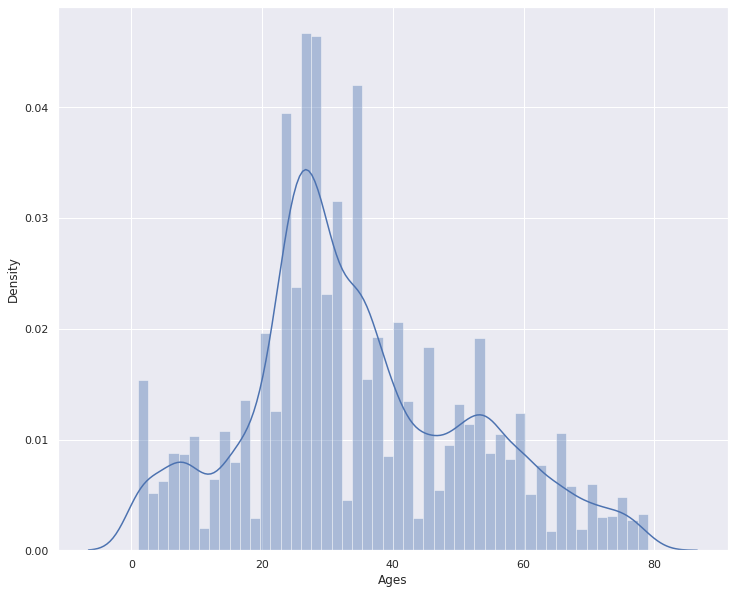

In [11]:
# we plot the distribution of ages again to check if it looks balanced enough
sns.distplot(df['Ages'], kde=True, bins=50);

We see that our distribution looks much better now so we will proceed ahead.

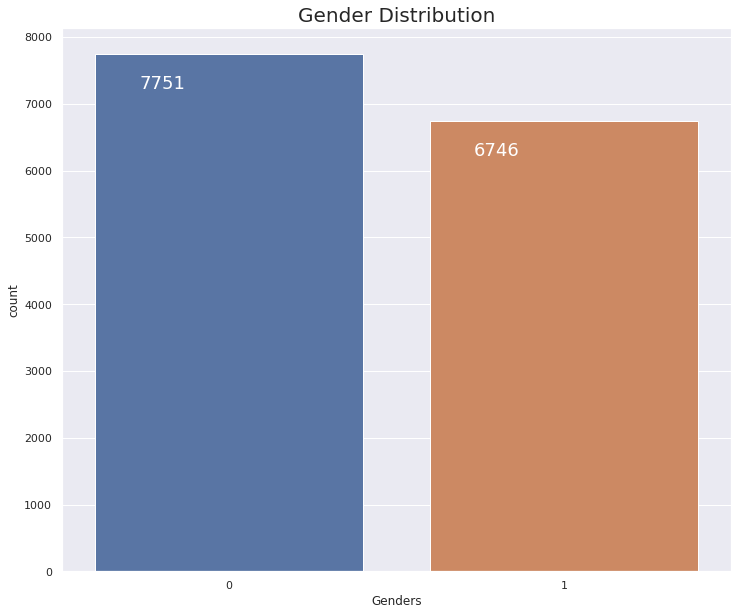

In [12]:
# we plot the countplot of our Genders to see if they are balanced in our dataset
ax = sns.countplot(df['Genders'])
ax.set_title('Gender Distribution', fontsize=20)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
plt.show()

We see that our genders and pretty much balanced enough so we will proceed ahead.

Next, we will be reducing the size of all the images in our dataset to 100x100 pixels. We do this partly because of the limited resources available in Google Colab.

In [13]:
# we resize all our images and apply anti-aliasing
x = []
for i in tqdm(range(len(df))):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((100,100), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
x = np.array(x)

100%|██████████| 14497/14497 [00:26<00:00, 546.81it/s]


In [14]:
# we create the train test splits of our two target labels age and gender for our respective models

y_age = df['Ages']
y_gender = df['Genders']
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=45)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender, random_state=45)

We first train our Age model.

In [15]:
# we initialize our DenseNet121 pre-trained model, set the last 15 layers as trainable and compile the model with set parameters

dn_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(100,100,3))

for layer in dn_model.layers[:-15]:
    layer.trainable = False

x = dn_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=64, activation='relu')(x)
output  = Dense(units=1)(x)
agemodel = Model(dn_model.input, output)

opt = tf.keras.optimizers.Adam(learning_rate=1e-5) # tuned
agemodel.compile(loss='mean_squared_error',
             optimizer=opt)

In [16]:
# we use keras image preprocessing tools to generate train and test image data and fit into our model

datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

# defining a Callback class that stops training if validation loss reaches 40
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<40):
      print("\nReached validation loss of 40 so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

history1 = agemodel.fit(train1, epochs=60, shuffle=True, validation_data=test1, callbacks=callbacks)

Epoch 1/60
363/363 [==============================] - 71s 144ms/step - loss: 1254.5569 - val_loss: 990.3911
Epoch 2/60
363/363 [==============================] - 46s 126ms/step - loss: 703.4293 - val_loss: 472.6356
Epoch 3/60
363/363 [==============================] - 46s 126ms/step - loss: 357.5905 - val_loss: 275.5917
Epoch 4/60
363/363 [==============================] - 46s 126ms/step - loss: 255.5718 - val_loss: 211.0513
Epoch 5/60
363/363 [==============================] - 46s 125ms/step - loss: 212.0361 - val_loss: 172.2334
Epoch 6/60
363/363 [==============================] - 49s 135ms/step - loss: 182.4248 - val_loss: 150.2948
Epoch 7/60
363/363 [==============================] - 46s 126ms/step - loss: 164.8998 - val_loss: 136.8662
Epoch 8/60
363/363 [==============================] - 47s 129ms/step - loss: 153.8408 - val_loss: 128.6303
Epoch 9/60
363/363 [==============================] - 45s 124ms/step - loss: 146.5797 - val_loss: 123.2182
Epoch 10/60
363/363 [===============

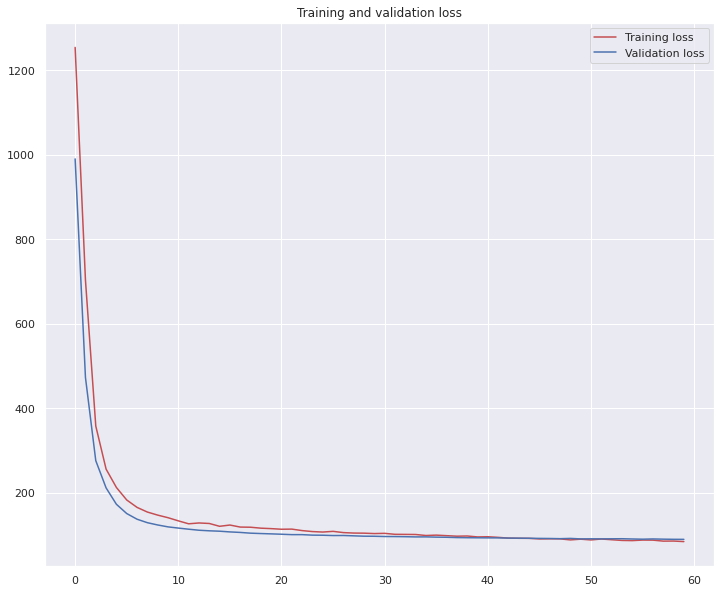

In [17]:
# we plot the training and validation loss to visually interpret if our model bias and variance

loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

We see that we have a very stable training and validation loss graphs which shows that our model can generalize well and is not overfitted neither underfitted.

Now, we will train our Gender model.

In [18]:
# we initialize our DenseNet121 pre-trained model, set the last 15 layers as trainable and compile the model with set parameters

dn_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(100,100,3))

for layer in dn_model.layers[:-15]:
    layer.trainable = False

x = dn_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=1, activation="sigmoid")(x)
genmodel = Model(dn_model.input, output)

opt = tf.keras.optimizers.Adam(learning_rate=1e-5) # tuned
genmodel.compile(loss='binary_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [19]:
# we use keras image preprocessing tools to generate train and test image data and fit into our model

datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=32)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=32)

# defining a Callback class that stops training if validation accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nReached validation accuracy of 95% so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

history2 = genmodel.fit(train2, epochs=60, shuffle=True, validation_data=test2, callbacks=callbacks)

Epoch 1/60
363/363 [==============================] - 60s 136ms/step - loss: 0.7598 - accuracy: 0.5764 - val_loss: 0.5482 - val_accuracy: 0.7428
Epoch 2/60
363/363 [==============================] - 46s 125ms/step - loss: 0.6110 - accuracy: 0.6816 - val_loss: 0.4756 - val_accuracy: 0.7886
Epoch 3/60
363/363 [==============================] - 45s 125ms/step - loss: 0.5488 - accuracy: 0.7296 - val_loss: 0.4403 - val_accuracy: 0.8090
Epoch 4/60
363/363 [==============================] - 46s 126ms/step - loss: 0.5123 - accuracy: 0.7557 - val_loss: 0.4163 - val_accuracy: 0.8172
Epoch 5/60
363/363 [==============================] - 46s 127ms/step - loss: 0.4800 - accuracy: 0.7781 - val_loss: 0.3996 - val_accuracy: 0.8238
Epoch 6/60
363/363 [==============================] - 46s 126ms/step - loss: 0.4622 - accuracy: 0.7834 - val_loss: 0.3861 - val_accuracy: 0.8283
Epoch 7/60
363/363 [==============================] - 46s 126ms/step - loss: 0.4438 - accuracy: 0.7994 - val_loss: 0.3727 - val_ac

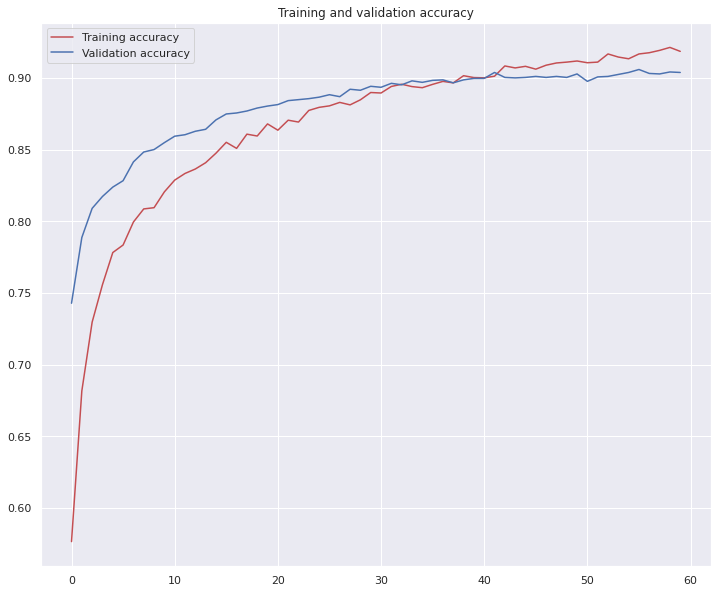

In [20]:
# we plot the training and validation accuracy to visually interpret our model stats
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

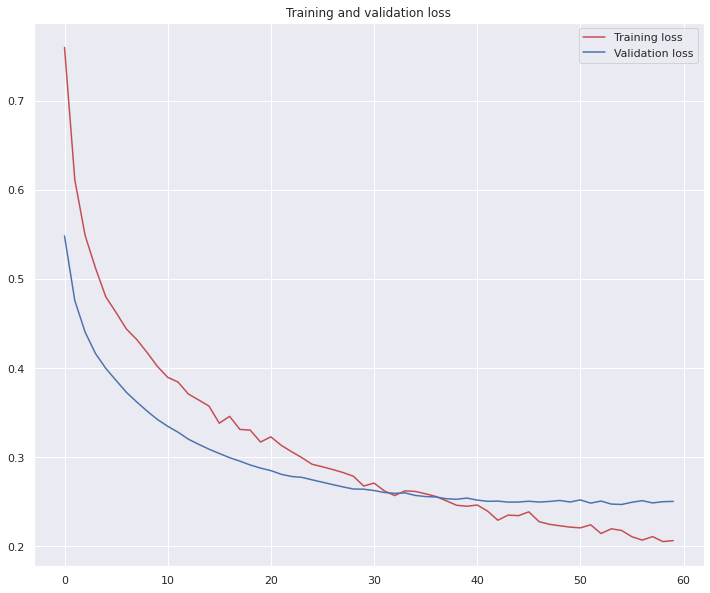

In [21]:
# we plot the training and validation loss to visually interpret our model stats
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

Here also we see that we have almost a very stable training and validation graphs with an accuracy of ~90% which shows that our model can generalize well and is not overfitted neither underfitted.

Next, we proceed forward to save our models as we can see that both our model performances are satisfactory enough but there is definitely a lot of scope for improvement. We could have achieved a much better result if we were not bound by Google Colab's limited resources and if we could use all the images in the dataset in their original shape of 200x200 to train our model.

In [22]:
# we save both our models to be used in our streamlit web-app
agemodel.save("/content/agemodel_densenet.h5")
genmodel.save("/content/genmodel_densenet.h5")

Next, we proceed to our streamlit web-app.

Data Source: [Link](https://www.kaggle.com/datasets/jangedoo/utkface-new)

Thank you for reading!! :D

Rishiraj Chowdhury (rishiraj5565@gmail.com)